# Assignment1. MNIST Digit Recogntion

이 과제에서는 손으로 쓴 숫자들의 이미지를 input으로 받아서 0~9 중 어느 숫자에 해당하는지를 분류하는 10-way Classification Problem을 풀어 볼 겁니다. 지금까지 실습은 가상의 인공 데이터셋이었다면 이번에는 real-world 데이터셋이니 좀 더 설레지 않나요?

`pytorch` 내에 이미 구현되어 있는 MNIST Dataset을 사용하여 데이터가 공급됩니다.  
대신 여러분들은 Model을 짜고 올바르게 Loss Function을 활용하는 코드를 작성하는데 집중해주시길 바랍니다.  

1. 현재 Linear Model만 구현이 되어 있습니다. MLP Model을 2.Model Architecture 부분에 구현해주세요.
2. MLP Model을 생성할 때 hidden unit 수와 hidden layer 수를 인풋으로 넣어주면 해당 값으로 MLP가 자동으로 생성되게 하는 코드를 구현해보세요.  
3. 다양한 hidden_unit과 hidden_layer 그리고 learning rate를 바꿔가면서 정확도의 변화를 알려주세요(이 때 모델이 고정되었다면 learning rate부터 바꿔가면서 튜닝해보세요. 차트나 표를 자유롭게 활용하여 결과를 보여주세요.  
4. 실험했던 결과 중 Test Set에 대한 Accuracy가 가장 높았던 실험 조건과 그때의 Accuracy를 알려주세요!  
5. 양식은 따로 없으며 이 주피터 노트북의 뒷부분에 추가로 1~4의 내용을 덧붙여서 정리하면 되겠습니다!

# 데이터 다운로드

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



102.8%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




7.1%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



112.7%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



50000 10000 10000


# 데이터 검사

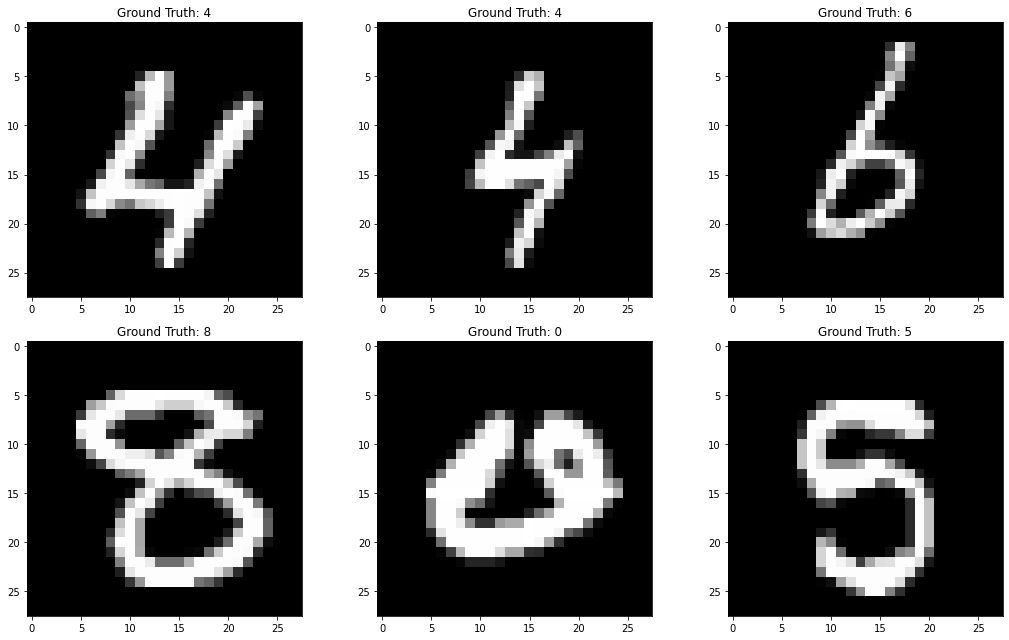

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [12]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x
    
class MLPModel(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features = in_dim, out_features = hidden_dim, bias=True)
        self.linear2 = nn.Linear(in_features = hidden_dim, out_features = out_dim, bias=True)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x
    

# costFunction 정의

In [13]:
cls_loss = nn.CrossEntropyLoss()

# model test

In [14]:
import numpy as np
m = MLPModel(28*28, 10, 200)
x = np.ones((1000, 28*28))
x = torch.Tensor(x)
pred_y = m(x)
print(np.shape(pred_y))

torch.Size([1000, 10])


# Train & Evaluation

In [16]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = MLPModel(28*28, 10, 200)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.numpy() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 159010 parameters
Epoch: 0, Train Loss: 1.147852110283454, Val Loss: 0.626540789121314, Test Acc: 86.07000000000001%
Epoch: 1, Train Loss: 0.5115130363827776, Val Loss: 0.4468683400486089, Test Acc: 89.0%
Epoch: 2, Train Loss: 0.40377467489608415, Val Loss: 0.3870472775984414, Test Acc: 90.2%
Epoch: 3, Train Loss: 0.35771765054949106, Val Loss: 0.35449581546119496, Test Acc: 90.94%
Epoch: 4, Train Loss: 0.32971349046053483, Val Loss: 0.33375701572321637, Test Acc: 91.51%
Epoch: 5, Train Loss: 0.3101802163797876, Val Loss: 0.31761054204234596, Test Acc: 91.67999999999999%
Epoch: 6, Train Loss: 0.2944912083847139, Val Loss: 0.30261375481569314, Test Acc: 92.14%
Epoch: 7, Train Loss: 0.2816205248046104, Val Loss: 0.29190789936464046, Test Acc: 92.43%
Epoch: 8, Train Loss: 0.27045059562339197, Val Loss: 0.28243058919906616, Test Acc: 92.67%
Epoch: 9, Train Loss: 0.2606102098970462, Val Loss: 0.2736312897899483, Test Acc: 92.92%
Epoch: 10, Train Loss: 0.2513756585090666, Val Loss: